## 6) Finding the best model

<h3>Table of Contents<span class="tocSkip"></span></h3>
<div class="toc"><ul class="toc-item"><li><span><a href="#Random-Forest-Model" data-toc-modified-id="Random-Forest-Model-1.1">Random Forest Model</a></span><ul class="toc-item"><li><span><a href="#Hyperparameter-tuning" data-toc-modified-id="Hyperparameter-tuning-1.1.1">Hyperparameter tuning</a></span></li><li><span><a href="#Test-Result" data-toc-modified-id="Test-Result-1.1.2">Test Result</a></span></li></ul></li></ul></div>

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

plt.style.use("seaborn-white")
plt.rcParams["font.size"] = 14
colors = sns.color_palette("Paired")

In [2]:
X_train_res = pd.read_csv(f"data/X_train_res.csv", index_col = 0)
y_train_res = np.ravel(pd.read_csv(f"data/y_train_res.csv", index_col = 0))
X_test = pd.read_csv(f"data/X_test.csv", index_col = 0)
y_test = np.ravel(pd.read_csv(f"data/y_test.csv", index_col = 0))

In [3]:
filename = 'models/rfc_model.sav'
rfc = pickle.load(open(filename, 'rb'))

### Random Forest Model

#### Hyperparameter tuning

In [4]:
param_grid_rfc = {"n_estimators": [100, 200, 300, 400, 500, 600],
               "max_features": ["auto", "sqrt", "log2"],
               'max_depth': [20, 30, 40, 50, 60, 70, None],
               'min_samples_split': [2, 3, 4, 5],
               'min_samples_leaf': [1, 2, 3, 4],
               'bootstrap': [True, False]}


In [5]:
random_grid_rfc = RandomizedSearchCV( 
    rfc,
    param_grid_rfc, 
    scoring = 'balanced_accuracy', 
    cv = 10)

In [6]:
random_grid_rfc.fit(X_train_res, y_train_res);

In [7]:
# Store the results in a data frame
random_rfc_cv_results = random_grid_rfc.cv_results_

random_grid_rfc_results = pd.DataFrame(
    {
        'model_hyperparams': random_rfc_cv_results['params'],
        'mean_val_score': random_rfc_cv_results['mean_test_score'],
        'std_val_score': random_rfc_cv_results['std_test_score']
     })

random_grid_rfc_results = random_grid_rfc_results.sort_values("mean_val_score", ascending = False
                                                     ).reset_index(drop = True)
random_grid_rfc_results.head(3)

,model_hyperparams,mean_val_score,std_val_score
0,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.695518,0.111433
1,"{'n_estimators': 300, 'min_samples_split': 2, ...",0.694299,0.115686
2,"{'n_estimators': 400, 'min_samples_split': 2, ...",0.690579,0.103986


In [8]:
# These are the parameters for the best model.
random_grid_rfc_results.iloc[0, 0]

{'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

The randomized search gives a slight improvement in the model's performance.

#### Test Result

              precision    recall  f1-score   support

           0       0.58      0.56      0.57        55
           1       0.73      0.75      0.74        88

    accuracy                           0.68       143
   macro avg       0.66      0.66      0.66       143
weighted avg       0.68      0.68      0.68       143

Balanced accuracy score: 65.68181818181817%


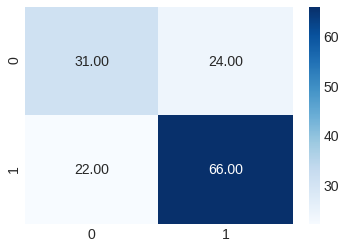

In [9]:
best_rfc_model = random_grid_rfc.best_estimator_
best_rfc_predictions = best_rfc_model.predict(X_test)

print(classification_report(y_test, best_rfc_predictions))
print(f"Balanced accuracy score: {metrics.balanced_accuracy_score(y_test, best_rfc_predictions)*100}%")
best_rfc_cm = confusion_matrix(y_test, best_rfc_predictions)
sns.heatmap(best_rfc_cm, annot=True, fmt='.2f', cmap = "Blues");

The ROC Curve below shows the difference between the training and the testing accuracy regarding the false and true positive rates.

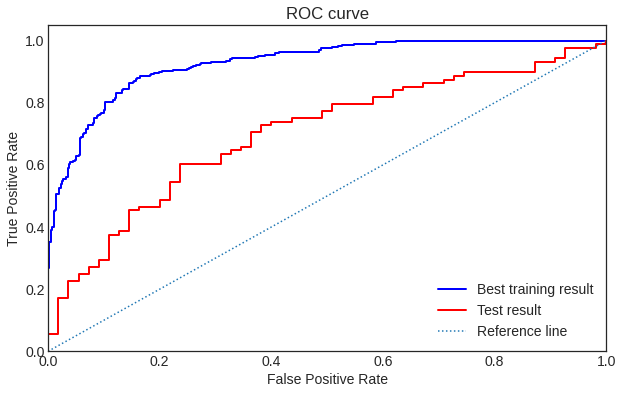

In [10]:
predictions_train = best_rfc_model.predict_proba(X_train_res)[:, 1]
predictions_test = best_rfc_model.predict_proba(X_test)[:, 1]

fpr_train, tpr_train, _ = metrics.roc_curve(y_train_res, predictions_train)
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, predictions_test)

fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(fpr_train, tpr_train, "b", linewidth=2, markersize=4, label="Best training result")
plt.plot(fpr_test, tpr_test, "r", linewidth=2, markersize=4, label="Test result")
plt.plot([0, 1], [0, 1], linestyle = ":", label = "Reference line")

plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.legend();

In [11]:
pd.DataFrame(best_rfc_predictions).to_csv("data/best_rfc_predictions.csv")

In [12]:
filename = 'models/best_rfc_model.sav'
pickle.dump(best_rfc_model, open(filename, 'wb'))